<h1 style="font-size:30px;">Transfer Learning using VGG-16 (as a Feature Extractor)</h1>  

In this notebook, we will learn how to train an Image Classifier on our custom data by using a pretrained model. We will continue with the VGG-16 network architecture but we instantiate the convolutional base of the network with weights that have been pre-trained on the ImageNet dataset. We will add our own classification layer and only train that portion of the network on the **types of balls** dataset to demonstrate that using a pre-trained convolutional base can be an effective approach for adapting a network to a new problem type. This technique is called **transfer learning**.

<img src='https://opencv.org/wp-content/uploads/2022/03/c4_03_cnn_vgg_pretrained_base_balls.png' width=1000 align='center'><br/>

## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Download and Extract the Dataset](#2-Download-and-Extract-the-Dataset)
* [3 Dataset and Training Configuration](#3-Dataset-and-Training-Configuration)
* [4 Modeling VGG-16](#4-Modeling-VGG-16)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import (
    MultipleLocator, FormatStrFormatter
)
from dataclasses import dataclass 

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
SEED_VALUE = 42 

## 1 System Configuration

In [ ]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


## 2 Download and Extract the Dataset

In [ ]:
def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
download_file( 
    'https://www.dropbox.com/s/6nrjxr2ycnpcy63/dataset_balls.zip?dl=1',
    'dataset_balls.zip'
)
    
unzip(zip_file='dataset_balls.zip')

Extracted all


## 3 Dataset and Training Configuration

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3
    BATCH_SIZE:  int = 32
    DATA_ROOT_TRAIN:   str = 'dataset_balls/train'
    DATA_ROOT_VALID:   str = 'dataset_balls/valid'
        
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 32
    EPOCHS:         int   = 51
    LEARNING_RATE:  float = 0.0001
    CHECKPOINT_DIR: str   = './saved_models_balls'

## 4 Modeling VGG-16

The Keras API provides the following utility that is used to instantiate a VGG-16 model which can be initialized with either pre-trained weights from ImageNet or random initial weights. **In this notebook, we will load the model with weights from the ImageNet dataset.** For more information on the VGG-16 model available in Keras, refer to the: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16" target="_blank">Keras VGG-16 Model API</a>
```python
tf.keras.applications.vgg16.VGG16(include_top=True, 
                                  weights='imagenet', 
                                  input_tensor=None,
                                  input_shape=None, 
                                  pooling=None, 
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )
```
### 4.1 VGG Convolutional Base

We begin by creating a model of the VGG-16 convolutional base. We can do this by instantiating the model and setting `include_top = False` which excludes the fully connected layers. **In the previous notebook, we initialized the convolutional base with random weights so we could train the model from scratch, however, here, we will instantiate the model with weights from the ImageNet dataset.**

In [ ]:
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
# Set the `trainable` attribute of the convolutional base to `False` so that the weights are not changed.
vgg16_conv_base.trainable = False
print('All weights trainable, fine tuning...')

Loading model with ImageNet weights...
58900480/58889256 [==============================] - 1s 0us/step
All weights trainable, fine tuning...


In [ ]:
print(vgg16_conv_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.2 Add the Classification Layer
Since we intend to train and use the model to classify balls from the Types of Balls dataset (which has only 10 classes), we will need to add our own classification layer. In this example, we have chosen to use just a single fully connected dense layer that contains 256 nodes, followed by a softmax output layer that contains 10 nodes for each of the 10 classes. The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset. This is the same approach we used in the previous notebook. 

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
    
x = tf.keras.applications.vgg16.preprocess_input(inputs)
    
x = vgg16_conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
    
# The final `Dense` layer with the number of classes.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
    
# The final model.
vgg16_model = keras.Model(inputs, outputs)

print(vgg16_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                             

### 4.3 Prepare the Training and Validation Dataset

In [ ]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                             image_size=(DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                             )

Found 1125 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


### 4.4 Display Sample Images

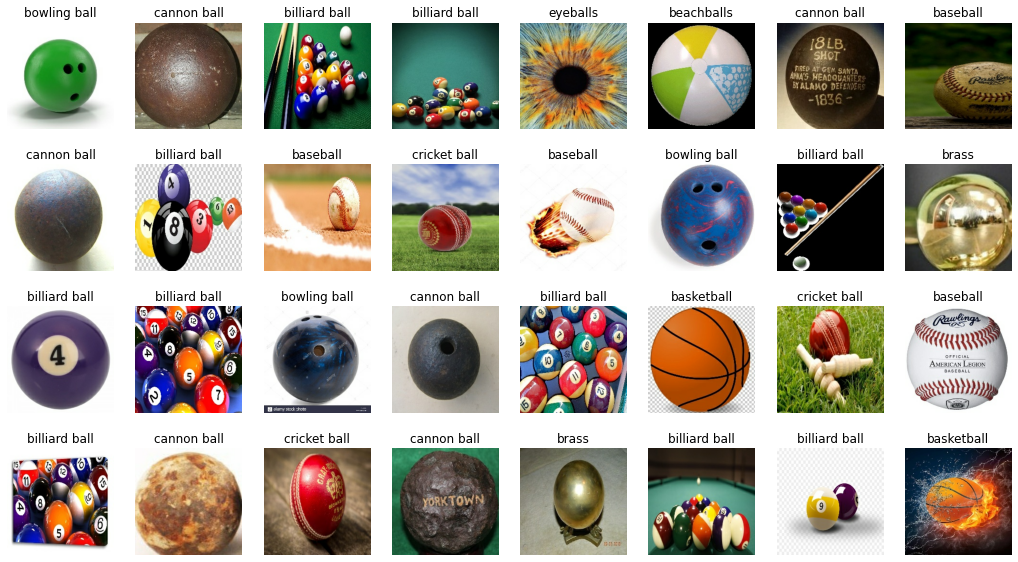

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.imshow(image_batch[idx].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[idx].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

### 4.5 Compile and Evaluate the Base Model Prior Final Training
At this point we can compile and evaluate the model before training the dense classifier.

In [ ]:
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   )  

In [ ]:
# Save best model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True,
                                                              )

Checking model accuracy before transfer learning.

In [ ]:
print(f"Model evaluation accuracy: {vgg16_model.evaluate(valid_dataset)[1]*100.:.3f}")

7/7 [==============================] - 10s 120ms/step - loss: 21.8541 - accuracy: 0.1000
Model evaluation accuracy: 10.000


### 4.6 Train the Model 

In [ ]:
# Train the Model.
training_results = vgg16_model.fit(train_dataset,
                                   validation_data=valid_dataset,
                                   epochs=TrainingConfig.EPOCHS,
                                   workers=4,
                                   use_multiprocessing=True, 
                                   callbacks=model_checkpoint_callback,
                                  )

Epoch 1/51
36/36 [==============================] - 9s 206ms/step - loss: 2.8585 - accuracy: 0.7964 - val_loss: 0.4894 - val_accuracy: 0.9450
Epoch 2/51
36/36 [==============================] - 7s 194ms/step - loss: 0.0747 - accuracy: 0.9947 - val_loss: 0.2975 - val_accuracy: 0.9750
Epoch 3/51
36/36 [==============================] - 4s 108ms/step - loss: 0.0104 - accuracy: 0.9973 - val_loss: 0.3782 - val_accuracy: 0.9600
Epoch 4/51
36/36 [==============================] - 4s 108ms/step - loss: 9.0146e-05 - accuracy: 1.0000 - val_loss: 0.3741 - val_accuracy: 0.9600
Epoch 5/51
36/36 [==============================] - 4s 108ms/step - loss: 1.1202e-05 - accuracy: 1.0000 - val_loss: 0.3654 - val_accuracy: 0.9600
Epoch 6/51
36/36 [==============================] - 4s 108ms/step - loss: 7.7581e-06 - accuracy: 1.0000 - val_loss: 0.3649 - val_accuracy: 0.9600
Epoch 7/51
36/36 [==============================] - 4s 108ms/step - loss: 6.0622e-06 - accuracy: 1.0000 - val_loss: 0.3646 - val_accurac

### 4.7 Plot the Training Results

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

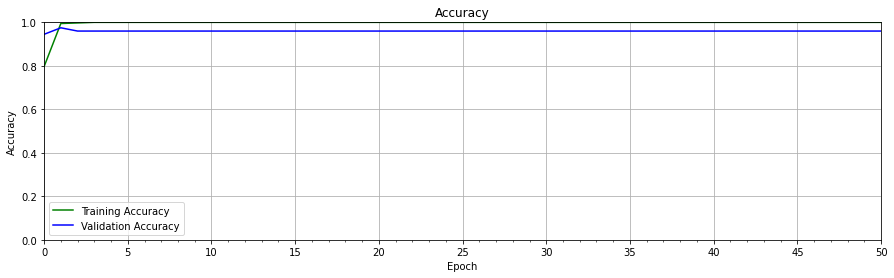

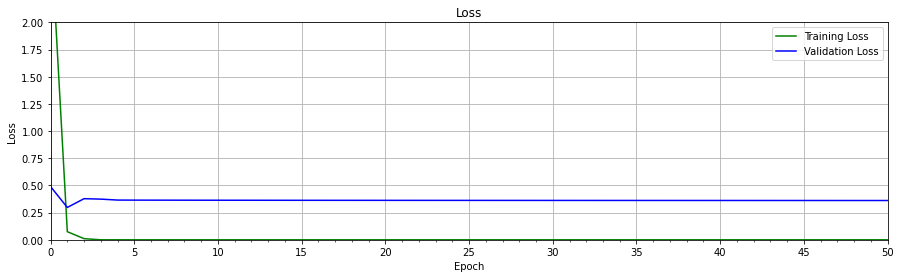

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])
 
max_loss = 2.0

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, max_loss],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 5 Model Evaluation 

In [ ]:
# Load saved model.
# Final evaluation accuracy on the validation set.
model = tf.keras.models.load_model(TrainingConfig.CHECKPOINT_DIR)
print(f"Model evaluation accuracy: {model.evaluate(valid_dataset)[1]*100.:.3f}")

7/7 [==============================] - 1s 80ms/step - loss: 0.2975 - accuracy: 0.9750
Model evaluation accuracy: 97.500


In [ ]:
def display_wrong_predictions(dataset, checkpoint_dir=None, checkpoint_version=0):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(), TrainingConfig.checkpoint_dir, f"version_{checkpoint_version}")
        
    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)
    
    plt.figure(figsize=(20, 15))
    num_rows = 4
    num_cols = 5
    class_names = dataset.class_names
    jdx = 0
    
    # Evaluate all the batches.
    for image_batch, labels_batch in dataset:
        
        # Predictions for the current batch.
        predictions = model.predict(image_batch)
        
        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            # Plot the images with incorrect predictions
            if pred_idx != truth_idx:
                
                jdx += 1
                
                if jdx > num_rows*num_cols:
                    # Break from the loops if the maximum number of images have been plotted
                    break
                
                ax = plt.subplot(num_rows, num_cols, jdx)
                title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
                title_obj = plt.title(title)
                plt.setp(title_obj, color='r')
                plt.axis("off")
                plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return 

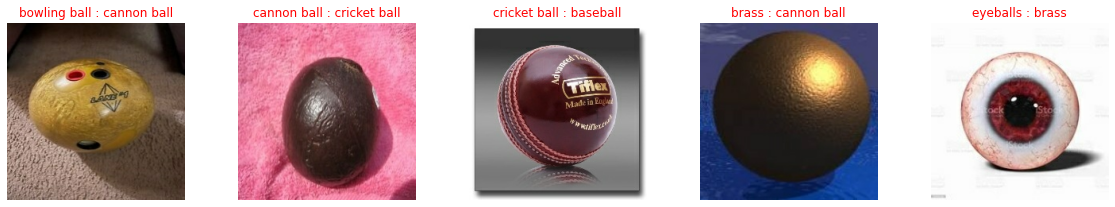

In [ ]:
display_wrong_predictions(valid_dataset, TrainingConfig.CHECKPOINT_DIR)

## 6 Conclusion

In this notebook, we demonstrated how to use **transfer learning** to achieve a higher validation accuracy on the **Types of Balls** dataset when compared to training the model from scratch. In the next notebook, we are going to take the same approach using a different dataset.